## [Reference](https://github.com/jsyoon0823/GAIN)

In [1]:
import tensorflow as tf
import numpy as np , pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import pprint
from IPython.display import clear_output
import warnings
import missingno as msno
warnings.filterwarnings('ignore')
pp = pprint.PrettyPrinter(width=30, indent=10)

In [2]:

device = ["/gpu:0" , "/gpu:1"]

In [3]:
import sys

sys.path.append('/home/advice/Python/SR/Custom/')
from cat_num_corrplot import *
from Init import *
from CompressData import *

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
data = pd.read_csv("./../Data/Rain/weatherAUS.csv")

In [7]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


## 명목형 수치형 한꺼번에 Corr Plot 그리기

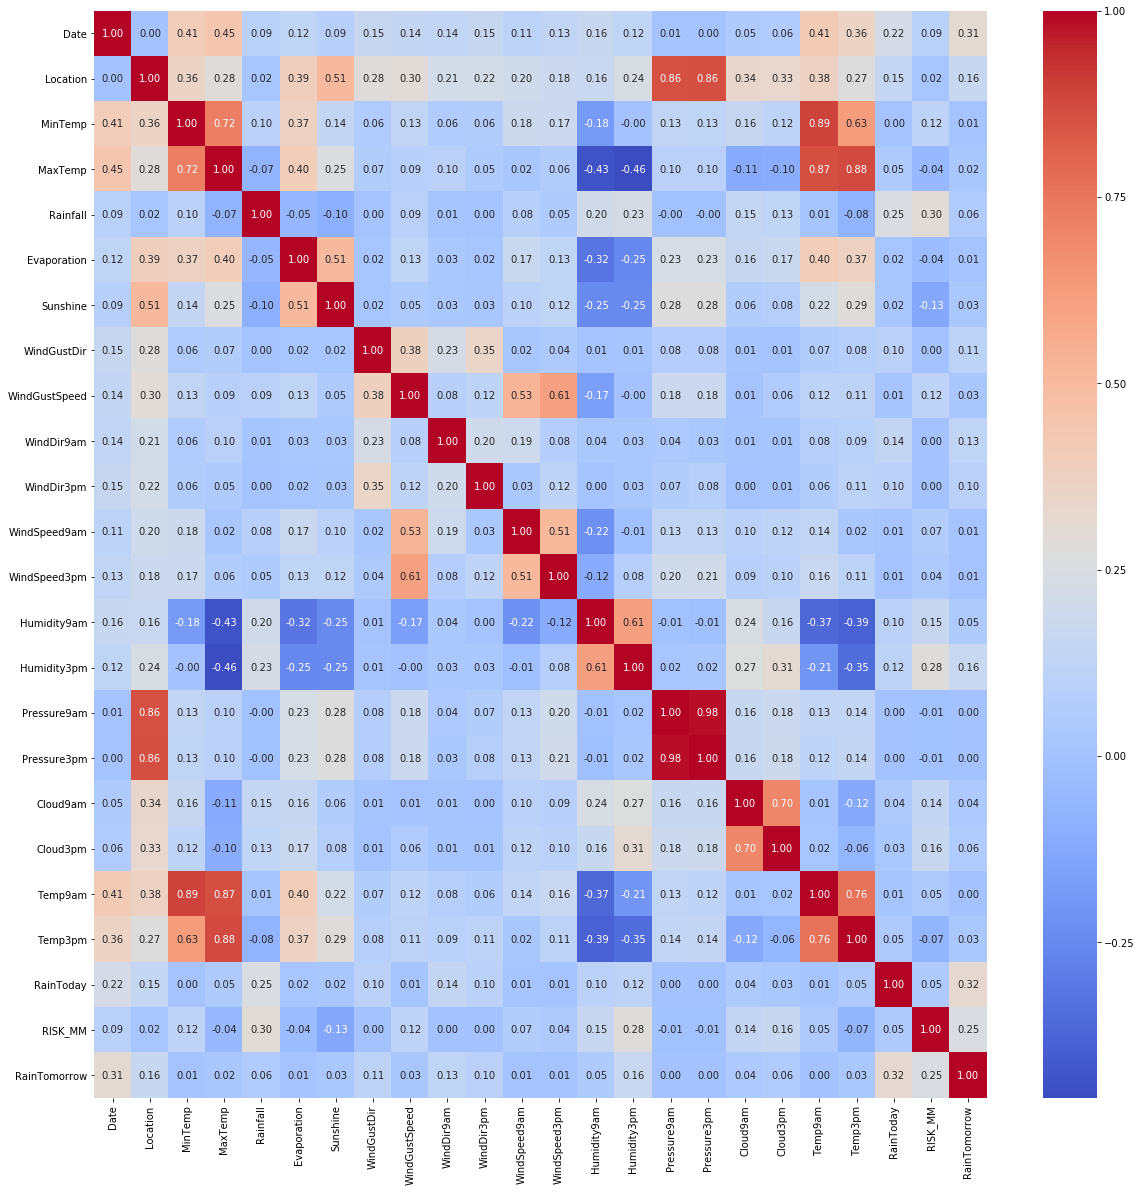

In [8]:
catcols = data.select_dtypes("object").columns.tolist()
vis_data = data.fillna(0)
results = associations(vis_data ,nominal_columns=catcols,return_results=True)

In [8]:
mem_usage(data)
type_memory(data)
data = int_memory_reduce(data)
data = float_memory_reduce(data)
data = object_memory_reduce(data)
mem_usage(data)

Average memory usage for float columns: 1.02 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 7.29 MB
Change Memroy : 0.00 MB == > 0.00 MB
Change Memroy : 18.44 MB == > 9.22 MB
Change Memroy : 58.35 MB == > 1.47 MB


'10.69 MB'

In [9]:
data.dtypes

Date             category
Location         category
MinTemp           float32
MaxTemp           float32
Rainfall          float32
Evaporation       float32
Sunshine          float32
WindGustDir      category
WindGustSpeed     float32
WindDir9am       category
WindDir3pm       category
WindSpeed9am      float32
WindSpeed3pm      float32
Humidity9am       float32
Humidity3pm       float32
Pressure9am       float32
Pressure3pm       float32
Cloud9am          float32
Cloud3pm          float32
Temp9am           float32
Temp3pm           float32
RainToday        category
RISK_MM           float32
RainTomorrow     category
dtype: object

## 결측치 시각화
* 추측컨데, 날씨가 너무 흐려서 관측소에서 데이터가 잡히지 않아서 발생하는 결측치 인 것 같다.
    * Cloud , Evaporation  과 같이 날씨가 우중충 할 때 이러한 수치들의 변화가 있을건데, 그때 영향을 받았을 거라 생각한다.

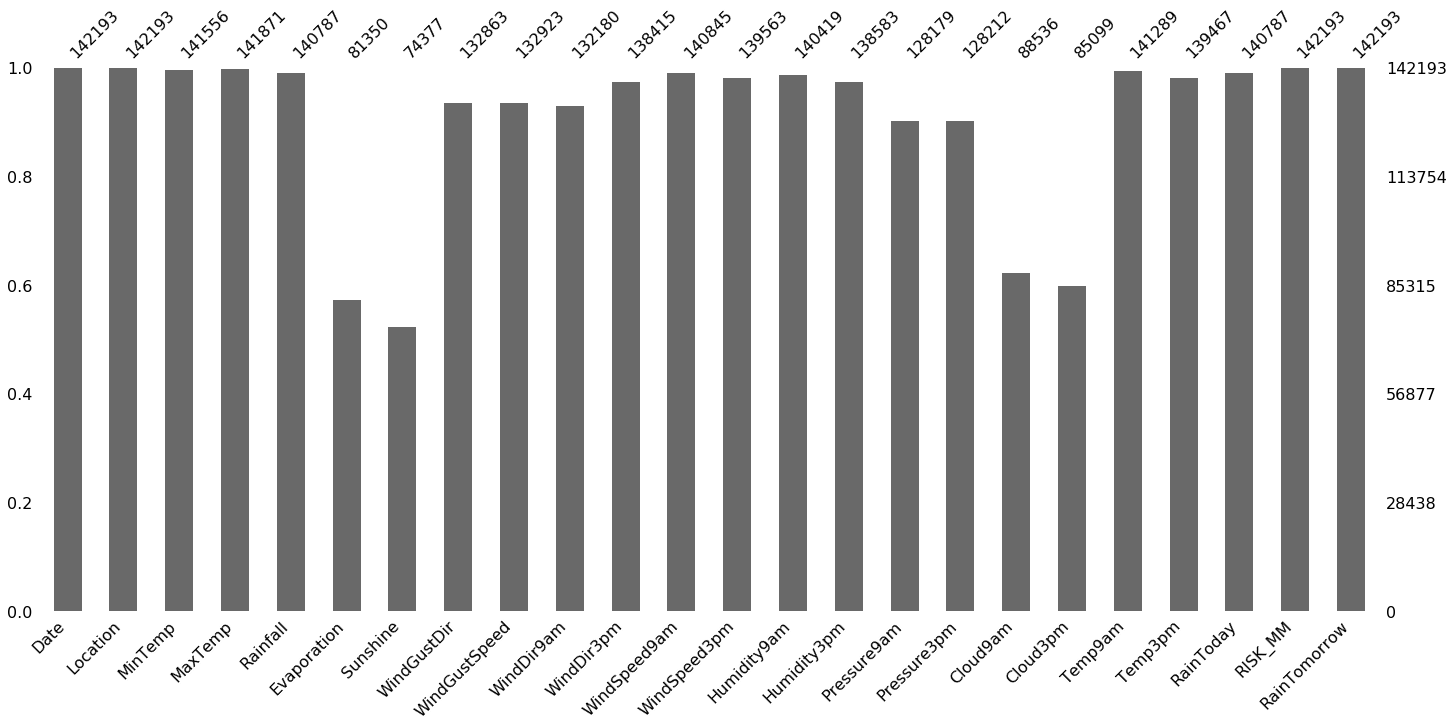

In [11]:
msno.bar(data)
plt.show()

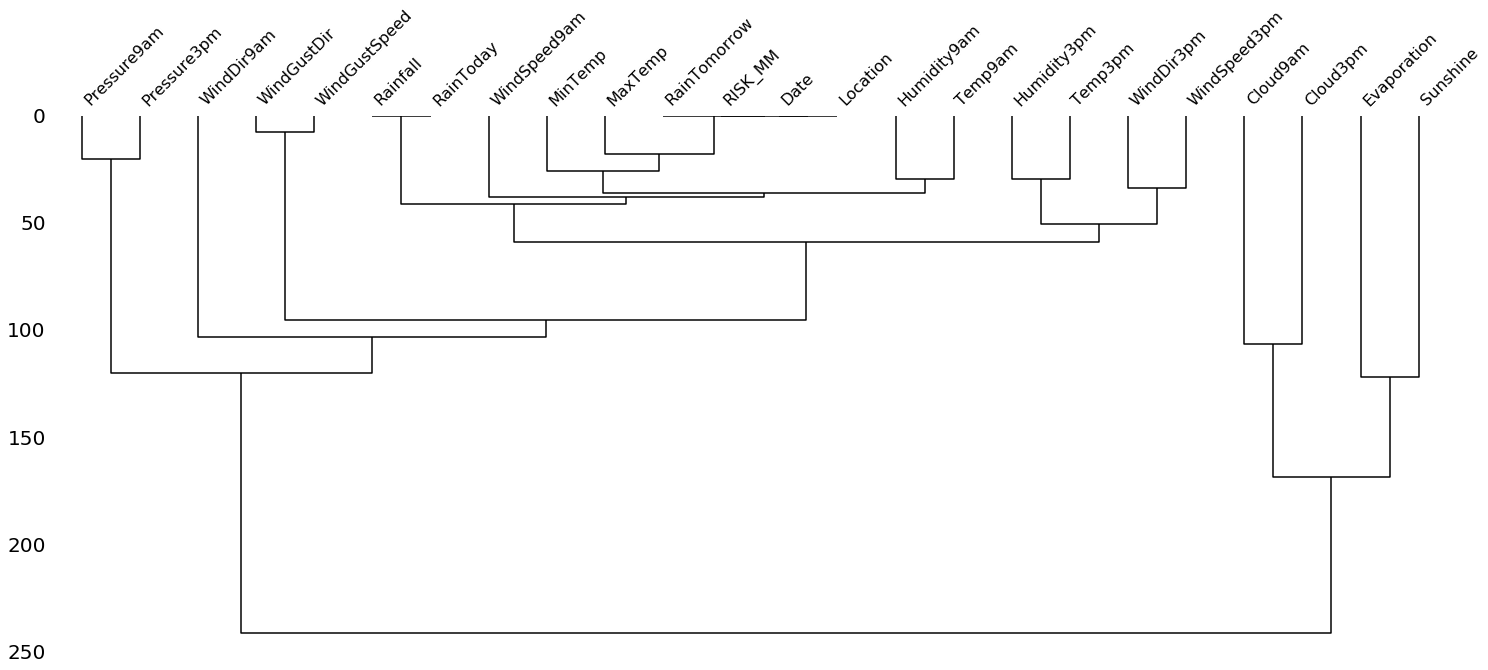

In [12]:
msno.dendrogram(data)

In [10]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 50 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)

연속형 variable : Date , count : 3436 
factor variable : Location, count : 49 
연속형 variable : MinTemp , count : 389 
연속형 variable : MaxTemp , count : 505 
연속형 variable : Rainfall , count : 679 
연속형 variable : Evaporation , count : 356 
연속형 variable : Sunshine , count : 145 
factor variable : WindGustDir, count : 16 
연속형 variable : WindGustSpeed , count : 67 
factor variable : WindDir9am, count : 16 
factor variable : WindDir3pm, count : 16 
factor variable : WindSpeed9am, count : 43 
factor variable : WindSpeed3pm, count : 44 
연속형 variable : Humidity9am , count : 101 
연속형 variable : Humidity3pm , count : 101 
연속형 variable : Pressure9am , count : 546 
연속형 variable : Pressure3pm , count : 549 
factor variable : Cloud9am, count : 10 
factor variable : Cloud3pm, count : 10 
연속형 variable : Temp9am , count : 440 
연속형 variable : Temp3pm , count : 500 
factor variable : RainToday, count : 2 
binary RainToday
연속형 variable : RISK_MM , count : 681 
factor variable : RainTomorrow, count : 2 
binary R

## 결측치를 cat.codes 하게 되면 `-1` 발생

In [11]:
a = data.WindGustDir.isna()
data.WindGustDir.cat.codes[a].head()

63     -1
64     -1
451    -1
1044   -1
1045   -1
dtype: int8

## Category 값 dict 형태로 저장하기

In [12]:
object_names = data.select_dtypes("category").columns
value_to_code = {}
code_to_value = {}
for object_name in object_names:
    print(object_name)
    col = data[object_name].dropna()
    keys = np.sort(col.cat.codes.unique())
    values = np.sort(col.unique())
    dic = dict(zip(values, keys))
    value_to_code[object_name] = dic
    dic = dict(zip(keys, values))
    code_to_value[object_name] = dic
    

Location
WindGustDir
WindDir9am
WindDir3pm
RainToday
RainTomorrow
Date


## 한꺼번에 replace 시키기 
* `na`는 그대로 유지하면서 

In [13]:
data = data.replace(value_to_code)

In [73]:
data.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,...,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM
0,2,13.0,13.0,14.0,20.0,24.0,8.0,NaN,0.0,0,...,NaN,NaN,44.0,71.0,22.0,1007.700012,1007.099976,16.900000,21.799999,0.0
1,2,14.0,6.0,15.0,4.0,22.0,NaN,NaN,0.0,0,...,NaN,NaN,44.0,44.0,25.0,1010.599976,1007.799988,17.200001,24.299999,0.0
2,2,15.0,13.0,15.0,19.0,26.0,NaN,2.0,0.0,0,...,NaN,NaN,46.0,38.0,30.0,1007.599976,1008.700012,21.000000,23.200001,0.0
3,2,4.0,9.0,0.0,11.0,9.0,NaN,NaN,0.0,0,...,NaN,NaN,24.0,45.0,16.0,1017.599976,1012.799988,18.100000,26.500000,1.0
4,2,13.0,1.0,7.0,7.0,20.0,7.0,8.0,0.0,0,...,NaN,NaN,41.0,82.0,33.0,1010.799988,1006.000000,17.799999,29.700001,0.2


In [77]:
data.columns

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow',
       'Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RISK_MM'],
      dtype='object')

In [76]:
object_names.values.tolist()
0 1, 2, 3 , 8, 9, 10

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow',
 'Date']

In [15]:
_, Dim = np.shape(data)

In [16]:
na_idx = data.isna().sum(axis = 1) > 0 

In [17]:
notna_data = data[~na_idx]
missing_data = data[na_idx]

(85773, 24)


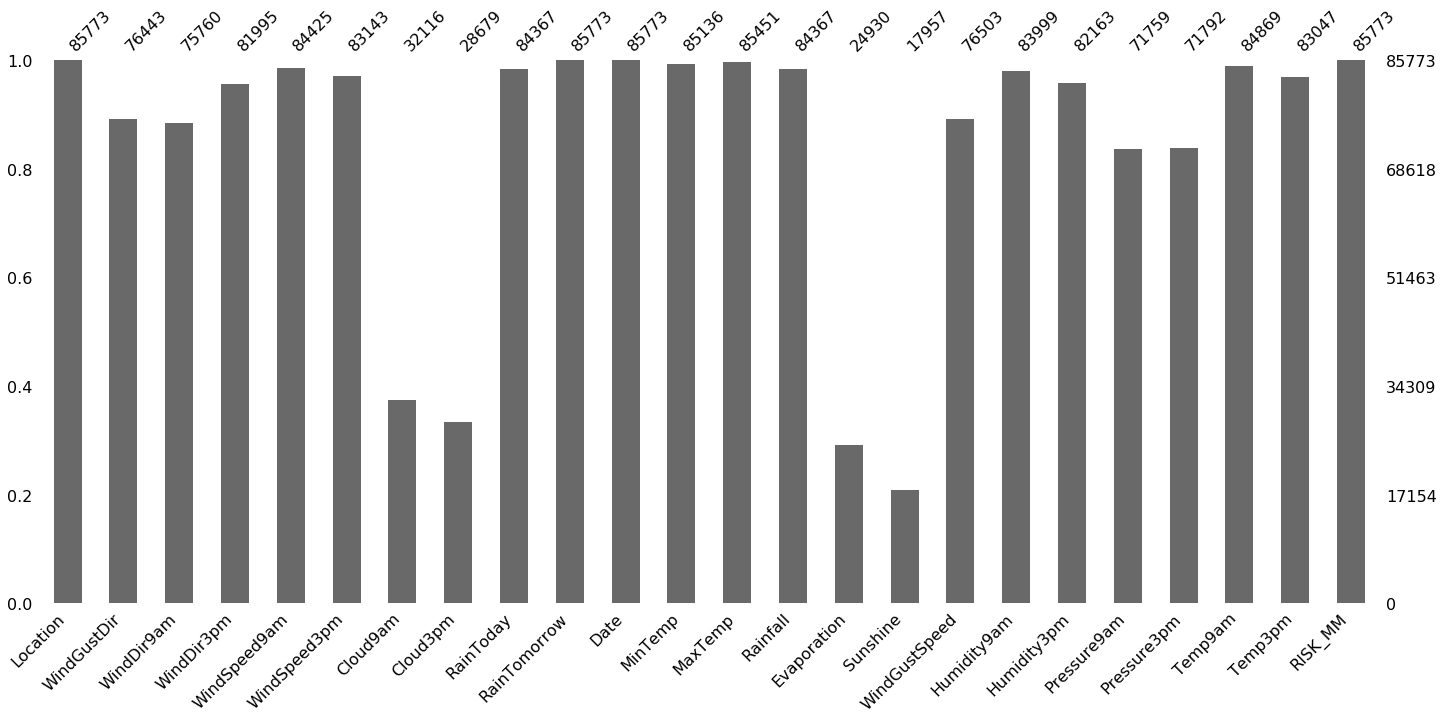

In [18]:
print(missing_data.shape)
msno.bar(missing_data);

## Columns 마다 missing 비율을 다르게 해서 줘야하는 것인지...

1. 전체 퉁쳐서 임의로 랜덤 비율만큼을 준다.
2. 비율을 고려해서 랜덤을 준다. 

> 일단 전체 랜덤 비율을 가지고 랜덤하게 주는 걸로 진행
* 이렇게 진행했을 때의 문제점은 비율이 작은 부분에 대해서도 Missing 이 있으면 결측치있는 데이터라고 하기 때문에 실제 학습에서 쓸 수 있는 데이터양이 줄어든다는 단점이 있다. 

## GAN에서 학습시킬 수 있고 Scaling 진행
* numeric {0 ~ 1}
* factor
    * 1 ,2 ,3, 4 -> (0 , 0.33 , 0.66 , 1) ? 이런식으로

In [19]:
scaler = MinMaxScaler(feature_range= (0.01,0.99))
S_data = scaler.fit_transform(notna_data)

## Missing 없는 데이터로 학습 나누기

In [20]:
trainX, testX  = train_test_split(S_data , test_size = 0.33, random_state = 42)

In [21]:
mb_size = 128
p_miss = len(missing_data)  / len(data)
print("Missing Ratio : ", p_miss)
p_hint = 0.9
alpha = 10

def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    ## p 기준으로 True False 
    B = A > p
    ## 맞으면 1 아니면 0 
    C = 1.*B
    """해당하는 배치사이즈만큼의 mask vector 와 hint vector 생성"""
    return C

Missing Ratio :  0.6032153481535659


In [22]:
Train_No , Test_No = len(trainX) , len(testX)

In [23]:
trainM = sample_M(Train_No, Dim, p_miss)
testM = sample_M(Test_No, Dim, p_miss)

In [37]:
pp.pprint(trainM[0 :5, :])

array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 1.]])


In [63]:
def gaussian_act(x) :
    return tf.exp(-x**2)

In [64]:
def G( x,z,m , reuse = tf.AUTO_REUSE) : 
    with tf.device(device[1]) :
        with tf.variable_scope("Generator" , reuse = reuse) as scope: 
            G_W1 = tf.get_variable("GW1",[Dim*2, h_dim], dtype=tf.float32 , initializer=tf.contrib.layers.xavier_initializer())
            G_b1 = tf.get_variable("GB1",[h_dim],dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W2 = tf.get_variable("GW2" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b2 = tf.get_variable("GB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W3 = tf.get_variable("GW3" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b3 = tf.get_variable("GB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W4 = tf.get_variable("GW4" ,[h_dim, Dim], dtype=tf.float32)
            G_b4 = tf.get_variable("GB4",[Dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            
            inp = m * x + (1-m) * z  # Fill in random noise on the missing values
            inputs = tf.concat(axis = 1, values = [inp,m])  # Mask + Data Concatenate
            G_h1 = tf.matmul(inputs, G_W1 ) + G_b1
            G_h1 = tf.contrib.layers.batch_norm(G_h1)
            #G_h1 = tf.layers.dropout(G_h1)
            G_h1 = tf.nn.leaky_relu(G_h1)
            G_h2 = tf.matmul(G_h1, G_W2 ) + G_b2
            G_h2 = tf.contrib.layers.batch_norm(G_h2)
            #G_h2 = tf.layers.dropout(G_h2)
            G_h2 = tf.nn.leaky_relu(G_h2)
            G_h3 = tf.matmul(G_h2, G_W3) + G_b3
            #G_h3 = tf.layers.dropout(G_h3)
            G_h3 = tf.contrib.layers.batch_norm(G_h3)
            G_h3 = tf.nn.leaky_relu(G_h3)
            
            G_log_prob = tf.matmul(G_h3, G_W4) # + G_b2 Bias는 일단 제외 
            G_log_prob = gaussian_act(G_log_prob)
            
        return G_log_prob 

    
def D(x, m, g, h,reuse=tf.AUTO_REUSE ):
    with tf.device(device[0]) :
        with tf.variable_scope( "Discriminator" ,reuse=reuse  ) as scope :
            inp = m * x + (1-m) * g  
            inputs = tf.concat(axis = 1, values = [inp,h])  # Hint + Data Concatenate
            D_W1 = tf.get_variable("DW1",[Dim*2, h_dim], dtype=tf.float32)
            D_b1 = tf.get_variable("DB1", [h_dim], dtype=tf.float32 , initializer=tf.constant_initializer(0.0))
            D_W2 = tf.get_variable("DW2",[h_dim, h_dim], dtype=tf.float32)
            D_b2 = tf.get_variable("DB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W3 = tf.get_variable("DW3",[h_dim, h_dim], dtype=tf.float32)
            D_b3 = tf.get_variable("DB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W4 = tf.get_variable("DW4",[h_dim, Dim], dtype=tf.float32)
            D_b4 = tf.get_variable("DB4",[Dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            
            D_h1 = tf.nn.leaky_relu(tf.matmul(inputs, spectral_norm(D_W1 , name ="sn1")) + D_b1)
            D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, spectral_norm(D_W2 , name ="sn2")) + D_b2)
            D_h3 = tf.nn.leaky_relu(tf.matmul(D_h2, spectral_norm(D_W3 , name ="sn3")) + D_b3)
            out = tf.matmul(D_h3 , D_W4) # + D_b4
        return out

In [65]:
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [66]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. Random Noise Vector
Z = tf.placeholder(tf.float32, shape = [None, Dim])

h_dim = 96

In [67]:
G_sample = G(X,Z,M)
D_prob = D(X, M, G_sample, H)

In [68]:
#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) * 2
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8)) / tf.reduce_mean(1-M)
MSE_train_loss = tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1  + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

t_vars = tf.trainable_variables()
print(t_vars)
d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]



with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    G_solver = tf.train.AdamOptimizer(1e-4 , beta1=0.5).minimize(G_loss, var_list=g_vars)
    D_solver = tf.train.AdamOptimizer(1e-4, beta1=0.5).minimize(D_loss, var_list=d_vars)

# Sessions
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

[<tf.Variable 'Generator/GW1:0' shape=(48, 96) dtype=float32_ref>, <tf.Variable 'Generator/GB1:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/GW2:0' shape=(96, 96) dtype=float32_ref>, <tf.Variable 'Generator/GB2:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/GW3:0' shape=(96, 96) dtype=float32_ref>, <tf.Variable 'Generator/GB3:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/GW4:0' shape=(96, 24) dtype=float32_ref>, <tf.Variable 'Generator/GB4:0' shape=(24,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm_1/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm_2/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Discriminator/DW1:0' shape=(48, 96) dtype=float32_ref>, <tf.Variable 'Discriminator/DB1:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Discriminator/DW2:0' shape=(96, 96) dtype=float32_ref>, <tf.Variable 'Discriminator/DB2:0' shape=(96,) dty

In [69]:
i = 1
iteration = 0
output = pd.DataFrame({"iter" : [iteration] , "train_loss" : [0] , "test_loss" : [0] })

In [122]:

notmissing_matrix = missing_data.isna().values == False
notmissing_matrix  = 1.* notmissing_matrix
missing_data = missing_data.fillna(0)
Missing_Data = scaler.fit_transform(missing_data)
testZ = sample_Z(len(Missing_Data), Dim) 
New_Missing = notmissing_matrix * Missing_Data + (1-notmissing_matrix) * testZ

In [123]:
New_Missing[0:10,0:10]

array([[0.05083333, 0.85933333, 0.85933333, 0.92466667, 0.16076923,
        0.28034483, 0.88111111, 0.28065189, 0.01      , 0.01      ],
       [0.05083333, 0.92466667, 0.402     , 0.99      , 0.04015385,
        0.25781609, 0.35429233, 0.78629522, 0.01      , 0.01      ],
       [0.05083333, 0.99      , 0.85933333, 0.99      , 0.15323077,
        0.30287356, 0.43690168, 0.255     , 0.01      , 0.01      ],
       [0.05083333, 0.27133333, 0.598     , 0.01      , 0.09292308,
        0.11137931, 0.6708435 , 0.2941314 , 0.01      , 0.01      ],
       [0.05083333, 0.85933333, 0.07533333, 0.46733333, 0.06276923,
        0.23528736, 0.77222222, 0.99      , 0.01      , 0.01      ],
       [0.05083333, 0.92466667, 0.85933333, 0.85933333, 0.15323077,
        0.28034483, 0.58019797, 0.22874933, 0.01      , 0.01      ],
       [0.05083333, 0.85933333, 0.794     , 0.85933333, 0.16076923,
        0.28034483, 0.11888889, 0.54358587, 0.01      , 0.01      ],
       [0.05083333, 0.85933333, 0.6633333

In [72]:
save_file = "./../Save_Model/GAIN-40000.meta"
saver = tf.train.import_meta_graph(save_file)
saver.restore(sess, tf.train.latest_checkpoint('./../Save_Model/'))

for i in range(10000):    
    #%% Inputs
    """
    55000 에서 , 앞에서 mb_size 만큼 뽑기 : mb_idx
    Z_mb  : mb_size , Dim 만큼의 uniform 뽑기 
    """
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    Z_mb = sample_Z(mb_size, Dim) 
    """
    위에서 만든 RANDOM 으로 Uniform 으로 생성된 miss 율에 따른 사이에 있으면 1 아니면 0 
    """
    M_mb = trainM[mb_idx,:]  
    """
    위에서 만든 RANDOM 으로 Uniform 으로 생성된 miss 율에 따른 사이에 있으면 1 아니면 0 
    """
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {X: X_mb, M: M_mb, Z: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, Z: New_X_mb, H: H_mb})
    
    
    
    output1 = pd.DataFrame({"iter" : [iteration] , "train_loss" : [MSE_train_loss_curr] , "test_loss" : [MSE_test_loss_curr] })
    output  = output.append(output1)
    iteration +=1 
    if MSE_test_loss_curr < 0.08 : 
        saver.save(sess, './../Save_Model/GAIN' ,  global_step= iteration)
    if (i+1) % 100 == 0 :
        output3 = sess.run(G_sample , feed_dict = {X: X_mb, M: M_mb, Z: New_X_mb})
        print(output3[0:10,0:10])
        output2 = sess.run(G_sample , feed_dict = {X: Missing_Data , M: notmissing_matrix, Z : New_Missing})
        print(output2[0:10,0:10])
        clear_output(wait= True)
        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
        output = output[output.iter>0]
        ax.plot(output.iter , output.train_loss , label ="train_loss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.plot(output.iter , output.test_loss , label ="test_loss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.set_title("Iter : {} , Train Loss : {} , Test Loss : {}".format( iteration ,  MSE_train_loss_curr, MSE_test_loss_curr ), fontsize= 30)
        ax.axhline(0.0, linewidth=4, color='r')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)    
        plt.show()
#     print('Iter: {}'.format(i))
#     print('Train_loss: {:.4f}'.format(MSE_train_loss_curr))
#     print('Test_loss: {:.4f}'.format(MSE_test_loss_curr))
#     print()


KeyboardInterrupt: 

## Model Save
* global_step 특정 step을 저장

In [49]:
saver = tf.train.Saver()
saver.save(sess, './../Save_Model/GAIN')

'./../Save_Model/GAIN'

## Data Impute!!

In [145]:
output2 = sess.run(G_sample , feed_dict = {X: Missing_Data , M: notmissing_matrix, Z : New_Missing})

In [146]:
output2 = scaler.inverse_transform(output2)

In [147]:
Generate = missing_data.values *  notmissing_matrix + (1-notmissing_matrix)*output2 

In [150]:
data_col = data.columns

In [151]:
Generate = pd.DataFrame(Generate)
Generate.columns = data_col
Generate[object_names.values.tolist()] = Generate[object_names.values.tolist()].round(0)

In [158]:
Concat = pd.concat([notna_data , Generate])

In [159]:
ImputeData = Concat.replace(code_to_value)

In [160]:
ImputeData.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,...,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM
5939,Cobar,SSW,ENE,SW,6.0,20.0,2.0,5.0,No,No,...,12.0,12.3,48.0,20.0,13.0,1006.299988,1004.400024,26.600000,33.400002,0.0
5940,Cobar,S,SSE,SSE,19.0,19.0,1.0,1.0,No,No,...,14.8,13.0,37.0,30.0,8.0,1012.900024,1012.099976,20.299999,27.000000,0.0
5942,Cobar,NNE,NNE,NNW,30.0,15.0,1.0,6.0,No,No,...,10.8,10.6,46.0,42.0,22.0,1012.299988,1009.200012,28.700001,34.900002,0.0
5943,Cobar,WNW,WNW,WSW,6.0,6.0,1.0,5.0,No,No,...,11.4,12.2,31.0,37.0,22.0,1012.700012,1009.099976,29.100000,35.599998,0.0
5944,Cobar,WNW,NW,WNW,17.0,13.0,1.0,6.0,No,No,...,11.2,8.4,35.0,19.0,15.0,1010.700012,1007.400024,33.599998,37.599998,0.0


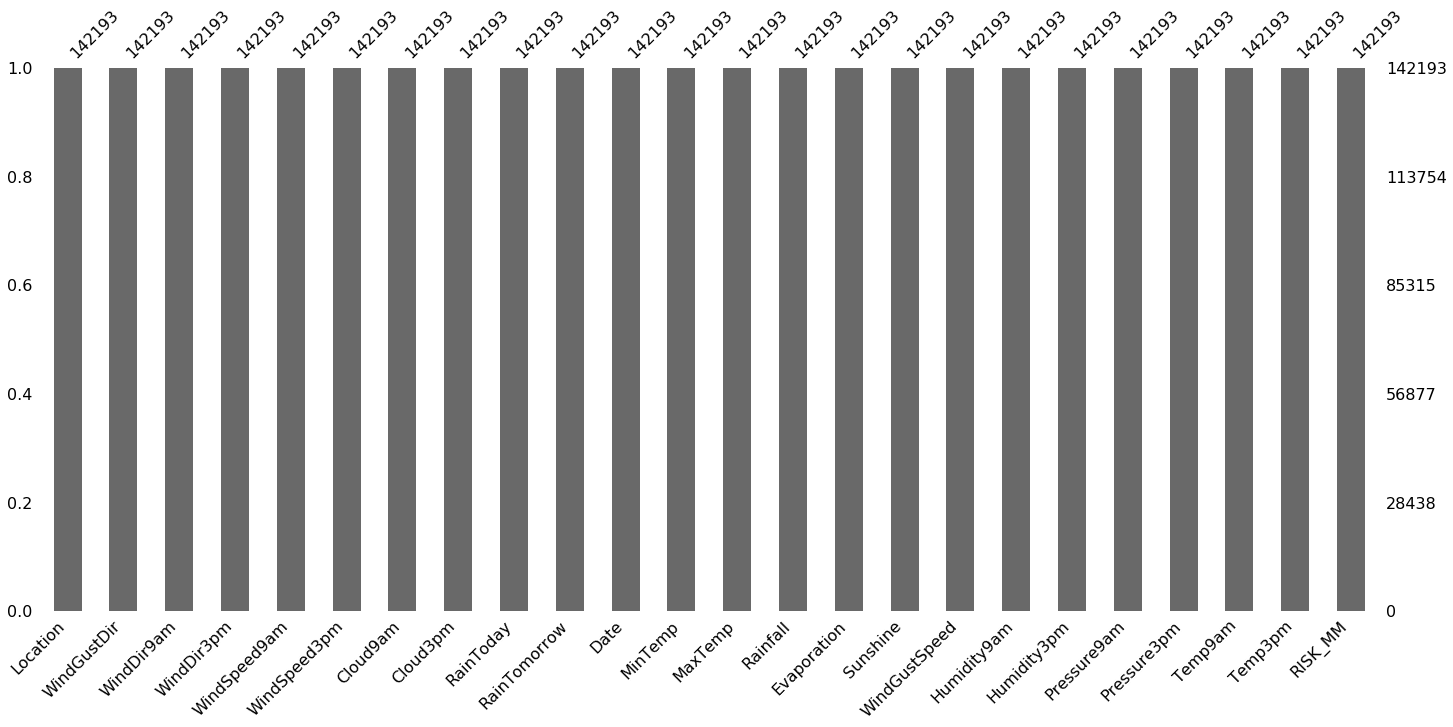

In [161]:
msno.bar(ImputeData)